# Workshop Tutorial: Gaussian Processes

Gaussian Processes (GPs) are a powerful probabilistic tool for signal fitting (among other things!). If you're interested to learn their inner workings, I highly recommend this interactive post: https://distill.pub/2019/visual-exploration-gaussian-processes/. Here I will only highlight the most relevant section:

>For a given set of training points, there are potentially infinitely many functions that fit the data. Gaussian processes offer an elegant solution to this problem by assigning a probability to each of these functions. The mean of this probability distribution then represents the most probable characterization of the data. Furthermore, using a probabilistic approach allows us to incorporate the confidence of the prediction into the regression result.

You can see that simply by definition GPs are extremely flexible and can be fitted to any number of signals - they're even capable of reproducing a full light curve if we want them to, at the cost of getting exactly ZERO astrophysical information out of the result! 

For our purposes, they are a great candidate that can be used to account for any signal that PHOEBE is unable to, which usually comes in the form of instrumental or astrophysical noise.

### GPs for instrumental noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
phoebe.interactive_checks_off()

Let's load the same TESS light curve used in the deterending tutorial and add it to a PHOEBE bundle. Here we'll use a downsampled version of the data, to speed up computations in PHOEBE.

In [2]:
data = np.loadtxt('data/noise_examples/tic91961.lc')[::5] #we're taking every 5th point of the light curve

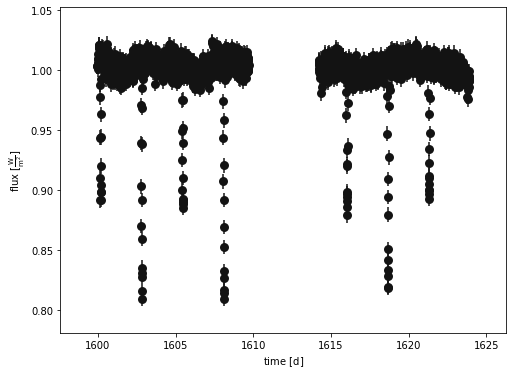

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [3]:
b = phoebe.default_binary()
b.add_dataset('lc', times=data[:,0], fluxes=data[:,1], sigmas=data[:,2], passband='TESS:T')
b.set_value('period', component='binary', value=5.282624782288264)
b.set_value('t0_supconj', value = 1602.8226998335715)
b.plot(show=True)

It's always useful to have at least a basic PHOEBE model of the data before adding GPs, so let's start with a simple lc_geometry estimator to get an approximate PHOEBE model of our data.

First, a bit of clean-up in the bundle that will allow us to run the estimator and speed up computations:

In [4]:
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('teffratio', solve_for='teff@secondary')

<ConstraintParameter: {teff@secondary@component} = {teffratio@binary@component} * {teff@primary@component} (solar units) => 6000.0 K>

In [5]:
b.flip_constraint('compute_phases', solve_for='compute_times')
b.set_value('compute_phases', np.linspace(-0.5,0.5,201))
b.set_value_all('distortion_method', 'sphere')
b.set_value_all('pblum_mode', 'dataset-scaled')

Finally, we add an estimator, run it and adopt the solution:

100%|████████████████████████████████████████| 201/201 [00:03<00:00, 53.15it/s]


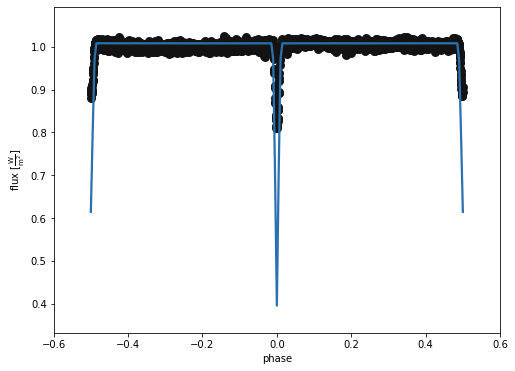

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [6]:
b.add_solver('estimator.lc_geometry', solver='lcgeom')
b.run_solver('lcgeom', solution='lcgeom_sol')

b.adopt_solution('lcgeom_sol')
b.run_compute()
b.plot(x='phase', show=True)

Not perfect but it'll do! Now we can move on to adding GPs to model the instrumental noise. 

PHOEBE supports two different GP models: 'sklearn', which uses the GP implementation in [scikit-learn](https://scikit-learn.org/stable/modules/gaussian_process.html), and [celerite2](https://celerite2.readthedocs.io/en/latest/). We have found that sklearn works better for instrumental noise, while celerite2 is designed with astrophysical noise in mind. 

Let's demonstrate how these two work on our case:

#### sklearn

In [7]:
b.add_gaussian_process('sklearn')

<ParameterSet: 17 parameters | contexts: feature, compute>

In [8]:
print(b['gp_sklearn01'])

ParameterSet: 5 parameters
      kernel@gp_sklearn01@feature: white
   noise_level@gp_sklearn01@fe...: 1.0
   noise_level_bounds@gp_sklea...: fixed
   alg_operation@gp_sklearn01@...: sum
   enabled@gp_sklearn01@phoebe...: True


The default sklearn kernel is 'white', which models, as the name suggests, white noise with a single 'noise_level' parameter. Let's see what the other options are:

In [9]:
b['kernel@gp_sklearn01'].choices

['constant',
 'white',
 'rbf',
 'matern',
 'rational_quadratic',
 'exp_sine_squared',
 'dot_product']

To see in more detail how each one of these works, refer to https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels. I think an RBF kernel should suffice for our trend:

In [10]:
b['kernel@gp_sklearn01'] = 'rbf'

GPs in PHOEBE are only fitted to the residuals of the data and the PHOEBE model: first the PHOEBE model is computed, then the residuals are calculated and passed on to the GP model to fit. You'll notice that in our sklearn GPs, the parameter bounds are set to 'fixed', which ensures that they won't be reoptimized by sklearn under the hood. As of yet, we offer no support to change these bounds and allow for under-the-hood optimizing of GP parameters to avoid confusion - you can still do it with the PHOEBE solvers, though!

In [11]:
b.run_compute(model='gps_rbf')

100%|████████████████████████████████████████| 201/201 [00:03<00:00, 52.61it/s]


<ParameterSet: 6 parameters | qualifiers: flux_scale, gps, times, fluxes_nogps, comments, fluxes>

Let's see the combined PHOEBE and RBF model! We'll plot the combined model, as well as the separate ones ('fluxes_nogps' yields the standalone PHOEBE model, while 'gps' the GP model):

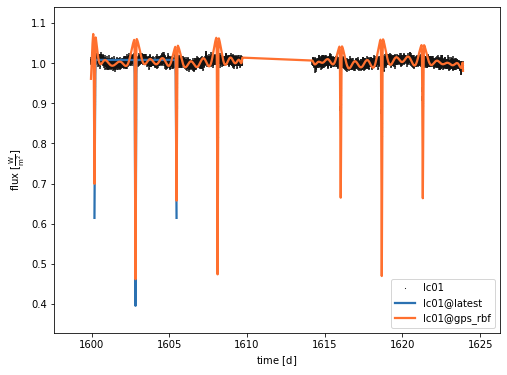

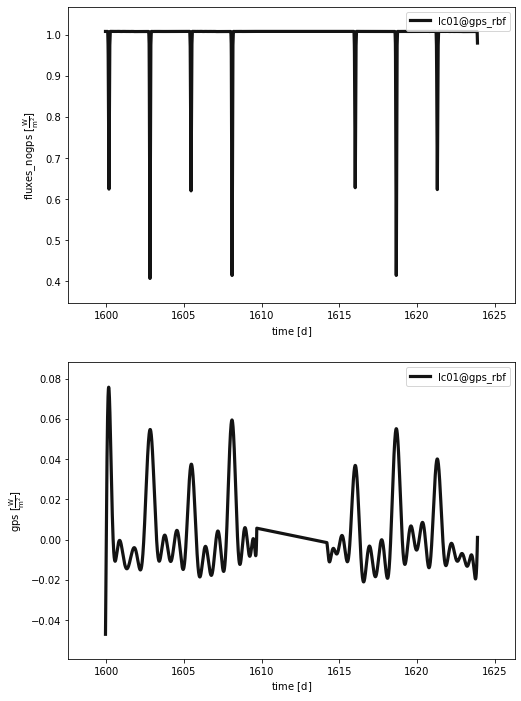

(<autofig.figure.Figure | 2 axes | 2 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [12]:
b.plot(s={'dataset': 0.005, 'model': 0.02}, ls={'model': '-'},
           marker={'dataset': '.'},
    # ylim=(0.950,1.075),
       legend=True,show=True)
b.plot(model='gps_rbf', y='fluxes_nogps', legend=True)
b.plot(model='gps_rbf', y='gps', legend=True, show=True)

Uh-oh, what happened? Remember how GPs can model anything under the Sun? Well, in this case, they detected large residuals in the eclipses because our estimator did a poor job of fitting those, so GPs tried to minimize those residuals instead! This behavior can easily get out of hand and have GPs fit the entire light curve instead of PHOEBE - something we refer to as 'signal stealing from GPs'. To aid in avoiding this, we have implemented an `gp_exclude_phases` parameter, which allows one to exclude entire chunks of the light curve from being fitted with GPs. 

Let's set that parameter to the `mask_phases` values returned from the lc_geometry estimator. Note that here the behavior is reversed compared to the standard PHOEBE use of `mask_phases`: in the PHOEBE model, all points but those in `mask_phases` are excluded, while in GPs, the points we pass on to `gp_exclude_phases` are ommited, while all others are kept for fitting.

In [13]:
b['gp_exclude_phases@lc01'] = b.get_value('fitted_values@lcgeom_sol')[-1]

Let's re-compute our model with this addition:

In [14]:
b.run_compute(model='gps_rbf_noeclipses')

100%|████████████████████████████████████████| 201/201 [00:03<00:00, 53.15it/s]


<ParameterSet: 6 parameters | qualifiers: flux_scale, gps, times, fluxes_nogps, comments, fluxes>

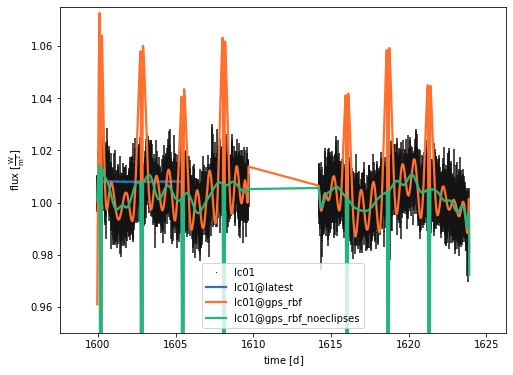

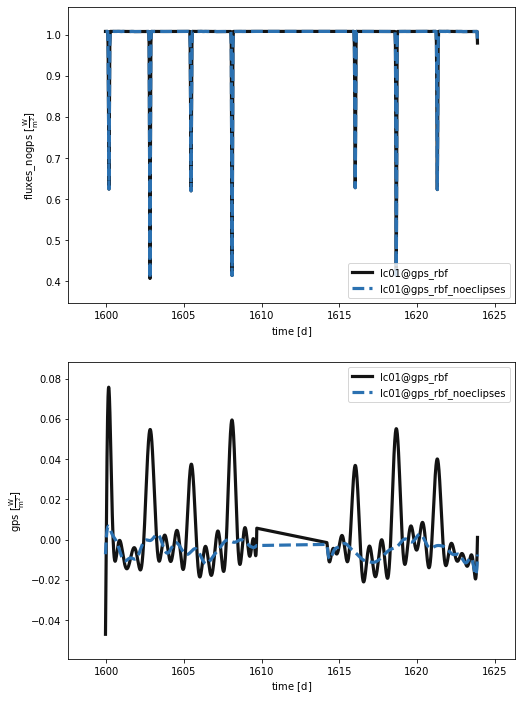

(<autofig.figure.Figure | 2 axes | 4 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [15]:
b.plot(s={'dataset': 0.005, 'model': 0.02}, ls={'model': '-'},
           marker={'dataset': '.'},
    ylim=(0.950,1.075),
       legend=True,show=True)
b.plot(model=['gps_rbf', 'gps_rbf_noeclipses'], y='fluxes_nogps', legend=True)
b.plot(model=['gps_rbf', 'gps_rbf_noeclipses'], y='gps', legend=True, show=True)

That looks much better now! Excluding the eclipses from being fitted with GPs ensured that GPs only fit the noise and not the eclipses.

Let's now compare to the celerite2 GP model for this case. We'll leave everything to the default values for this demonstration.

In [16]:
b.add_gaussian_process('celerite2')

<ParameterSet: 11 parameters | contexts: feature, compute>

In [17]:
print(b['gp_celerite201'])

ParameterSet: 7 parameters
    kernel@gp_celerite201@feature: sho
       rho@gp_celerite201@feature: 1.0
       tau@gp_celerite201@feature: 1.0
     sigma@gp_celerite201@feature: 1.0
       eps@gp_celerite201@feature: 1e-05
   alg_operation@gp_celerite20...: sum
   enabled@gp_celerite201@phoe...: True


In [18]:
b.run_compute()

ValueError: failed to pass checks
Run Checks Report: FAIL
WARNING: t0_supconj@binary is ~303 orbital cycles from t0@system, which could cause precision issues for time-dependent systems (2 affected parameters, affecting system,run_compute)
WARNING: underlying model will be computed at compute_times for lc01 but exposed at dataset times in order to include gaussian processes (5 affected parameters, affecting run_compute)
ERROR: mixing of GP kernels from sklearn and celerite2 is not supported. Remove or disable kernels from one (2 affected parameters, affecting run_compute)

As of yet, PHOEBE only supports one GPs "backend" at a time, either sklearn or celerite2. The two can't be mixed, however you can mix different kernels from the same module. So, let's disable the sklearn GP feature before moving on to compute the celerite2 GPs.

In [19]:
b.disable_feature('gp_sklearn01')

<ParameterSet: 4 parameters | qualifiers: kernel, length_scale_bounds, length_scale, alg_operation>

Let's run two models, similarly to what we did for the sklearn kernel: first without excluding the eclipses and then with setting the `exclude_phases` parameter to the eclipse edges returned from lc_geometry.

In [20]:
b['gp_exclude_phases_enabled@lc01'] = False
b.run_compute(model='gps_celerite2', overwrite=True)

100%|████████████████████████████████████████| 201/201 [00:03<00:00, 52.56it/s]


<ParameterSet: 6 parameters | qualifiers: flux_scale, gps, times, fluxes_nogps, comments, fluxes>

In [21]:
b['gp_exclude_phases_enabled@lc01'] = True
b.run_compute(model='gps_celerite2_noeclipses')

100%|████████████████████████████████████████| 201/201 [00:03<00:00, 53.28it/s]


<ParameterSet: 6 parameters | qualifiers: flux_scale, gps, times, fluxes_nogps, comments, fluxes>

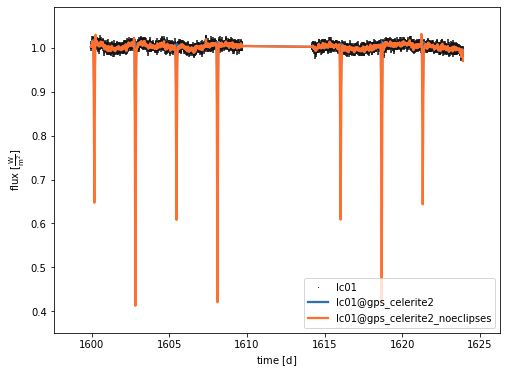

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [22]:
b.plot(['dataset', 'model'], model=['gps_celerite2', 'gps_celerite2_noeclipses'],
    s={'dataset': 0.005, 'model': 0.02}, ls={'model': '-'},
           marker={'dataset': '.'},
    # ylim=(0.950,1.075),
       legend=True,show=True)

This may look much better than the sklearn model on a first glance, but let's zoom in to see what *really* happens:

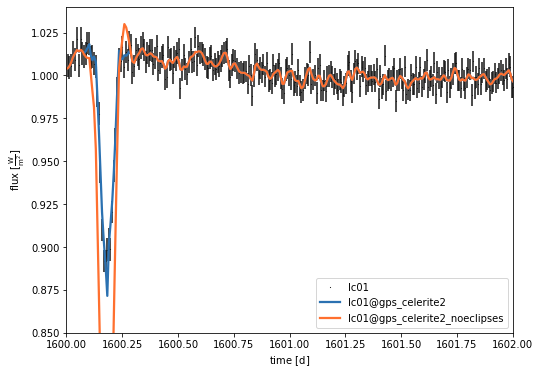

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [23]:
b.plot(['dataset', 'model'], model=['gps_celerite2', 'gps_celerite2_noeclipses'],
    s={'dataset': 0.005, 'model': 0.02}, ls={'model': '-'},
           marker={'dataset': '.'},
        ylim=(0.85,1.04), xlim=(1600,1602),
       legend=True,show=True)

This is a classic case of GPs overfitting the data: when we include the eclipse points in the fitting, ALL of the signal that originates from our PHOEBE model not fitting the data closely is suppressed by the addition of GPs. This is one safe way to ensure PHOEBE does absolutely nothing and whatever you get back from your PHOEBE model is far fromt he truth. Within MCMC, this will lead the PHOEBE parameteres to be completely unconstrained because all of the signal is accounted for by the GPs!

Therefore, in cases of instrumental noise, we recommend using the sklearn kernels - even some with basic default values are less prone to overfitting. If you want to delve a little deeper in the optimal kernel choice, see [this example](link) for how to utilize grid search and hyperparameter optimization (outside of Phoebe) to improve the GP model.

#### GPs for astrophysical noise

The situation is a little different when we're dealing with astrophysical noise. Let's see, for example, a case with tidally induced pulsations: KIC 3230227. This system has been discussed in great detail in [Guo et al. (2016)](https://ui.adsabs.harvard.edu/abs/2017ApJ...834...59G/abstract) and a working example of fitting the tidally induced pulsations with GPs is available in [this example](link).

In [24]:
data = np.loadtxt('data/noise_examples/kic3230227.lc')[:3000]

Let's load the data and set the period to its catalog values:

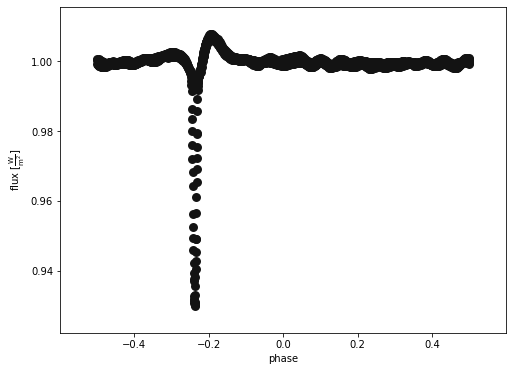

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [25]:
b = phoebe.default_binary()
b.add_dataset('lc', times=data[:,0], fluxes=data[:,1], sigmas=data[:,2], passband='TESS:T')
b.set_value('period', component='binary', value=7.0471062)
b.plot(x='phase', show=True)

*This system is actually rather complicated: there's periastron brightening which can be modeled both by GPs and PHOEBE (but we'd like to leave that job to PHOEBE as much as possible), the one visible eclipse is actually the secondary eclipse, and in the absence of RVs it practically impossible to constrain the orbit. For all of these intricacies please refer to the linked paper and example script. Here we will only focus on demonstrating the behavior of different GP kernels.*

Let's set some parameters that will help us reproduce the PHOEBE model as closely as possible (estimators won't cut it here!), which will allow us to focus more on the behavior of GPs:

In [26]:
b.set_value('t0_supconj', value=54958.702238+0.3233*7.0471062)
b.set_value('q', value=0.939)
b.set_value('ecc', value=0.6)
b.set_value('per0', -67)
b.set_value('teff@primary', value=8000)
b.set_value('teff@secondary', value=8100)
b.set_value('incl@binary', 73.42)
b.set_value('sma@binary', 23.64)
b.set_value('requiv@primary', 2.01)
b.set_value('requiv@secondary', 1.68)
b.set_value('gravb_bol@primary', 1.0)
b.set_value('gravb_bol@secondary', 1.0)
b.set_value('irrad_frac_refl_bol@primary', 1.0)
b.set_value('irrad_frac_refl_bol@secondary', 1.0)
b.set_value('teff@primary', 8000)
b.set_value('teff@secondary', 8177)

In [27]:
b.flip_constraint('compute_phases', solve_for='compute_times')
b.set_value('compute_phases', np.linspace(-0.5,0.5,201))
b.set_value_all('distortion_method', 'sphere')
b.set_value_all('pblum_mode', 'dataset-scaled')

100%|████████████████████████████████████████| 201/201 [00:03<00:00, 53.70it/s]


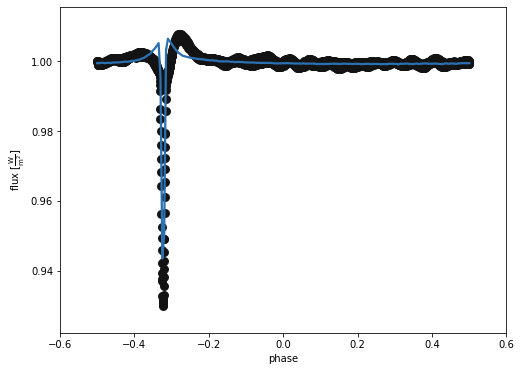

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [28]:
b.run_compute()
b.plot(x='phase', show=True)

The model is not ideal mainly because of all the shortcuts we have implemented to speed up the computation: the 201 phase points and spherical geometry. It's good enough for our purposes though so we won't bother too much with fixing that right now! 

It's pretty obvious that the "noise" in this case is periodic. So instead of shooting in the dark, we can run FFT to get the most powerful frequencies. It turns out that the two most powerful frequencies are the orbital one (as expected) and one at 1.969765 s$^{-1}$. Let's use this information to kickstart our GP models!

#### sklearn

The one periodic kernel available in sklearn is ExpSineSquared, so we'll use a combination of two `exp_sine_squared` kernels in PHOEBE with the above mentioned periodicities:

In [29]:
# setting the length scale to the same value as the periodicity helps prevent overfitting in periodic kernels (a good start, but not always ideal!)
b.add_gaussian_process('sklearn', kernel='exp_sine_squared', periodicity = b.get_value('period@binary'), length_scale=b.get_value('period@binary'))
b.add_gaussian_process('sklearn', kernel='exp_sine_squared', periodicity = 1./1.969765, length_scale=1./1.969765)

<ParameterSet: 17 parameters | contexts: feature, compute>

In [30]:
print(b['gp_sklearn01'])

ParameterSet: 7 parameters
      kernel@gp_sklearn01@feature: exp_sine_squared
   length_scale@gp_sklearn01@f...: 7.0471062
   periodicity@gp_sklearn01@fe...: 7.0471062
   length_scale_bounds@gp_skle...: fixed
   periodicity_bounds@gp_sklea...: fixed
   alg_operation@gp_sklearn01@...: sum
   enabled@gp_sklearn01@phoebe...: True


In [31]:
print(b['gp_sklearn02'])

ParameterSet: 7 parameters
      kernel@gp_sklearn02@feature: exp_sine_squared
   length_scale@gp_sklearn02@f...: 0.507674773386673
   periodicity@gp_sklearn02@fe...: 0.507674773386673
   length_scale_bounds@gp_skle...: fixed
   periodicity_bounds@gp_sklea...: fixed
   alg_operation@gp_sklearn02@...: sum
   enabled@gp_sklearn02@phoebe...: True


Let's also ensure that GPs are not trying to overcompansate for the PHOEBE model not fitting the eclipse (and periastron brightening) well:

In [32]:
b['gp_exclude_phases@lc01'] = [[-0.4,-0.2]]
b.run_compute(model='gps_sklearn_model')

100%|████████████████████████████████████████| 201/201 [00:03<00:00, 52.75it/s]


<ParameterSet: 6 parameters | qualifiers: flux_scale, gps, times, fluxes_nogps, comments, fluxes>

And the result (zoomed in so we can better see what GPs are doing):

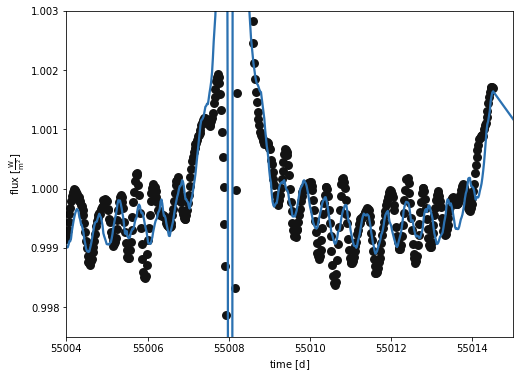

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [33]:
b.plot(model='gps_sklearn_model', x='times', xlim=(55004,55015), ylim=(0.9975,1.003), show=True)

#### celerite2

In [34]:
b.add_gaussian_process('celerite2', kernel='sho', sigma=2e-3, rho=7.0471062, Q=11/2)
b.add_gaussian_process('celerite2', kernel='sho', sigma=2e-3, rho=1/1.969765, Q=11/2)

<ParameterSet: 11 parameters | contexts: feature, compute>

In [35]:
print(b['gp_celerite201'])

ParameterSet: 7 parameters
    kernel@gp_celerite201@feature: sho
       rho@gp_celerite201@feature: 7.0471062
       tau@gp_celerite201@feature: 1.0
     sigma@gp_celerite201@feature: 0.002
       eps@gp_celerite201@feature: 1e-05
   alg_operation@gp_celerite20...: sum
   enabled@gp_celerite201@phoe...: True


100%|████████████████████████████████████████| 201/201 [00:03<00:00, 53.72it/s]


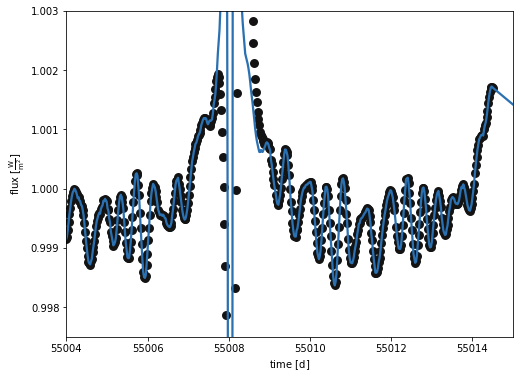

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [36]:
b.disable_feature('gp_sklearn01')
b.disable_feature('gp_sklearn02')
b.run_compute(model='gps_celerite2_model', overwrite=True)
b.plot(model='gps_celerite2_model', x='times', xlim=(55004,55015), ylim=(0.9975,1.003), show=True)

We can immediately see that celerite2 far outperforms sklearn when it comes to astrophysical signals!